In [1]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


# import tensorflow
# from tensorflow.compat.v1.keras.backend import get_session
# tensorflow.compat.v1.disable_v2_behavior()
# import shap

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing

import tensorflow as tf

import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Only using years 2010, 2011, 2012, 2013, and 2014 because of the auroral boundary database used only has those dates

In [2]:
file_load_df_cumulative = '../ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=['ID_SC', 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

mask_for_2010_to_2014 = [(df_train.index.year == 2010) | (df_train.index.year == 2011)
                         | (df_train.index.year == 2012) |(df_train.index.year == 2013)
                         | (df_train.index.year == 2014)]
df_train = df_train[mask_for_2010_to_2014[0]]
df_train = df_train.sort_values(by=['ID_SC', 'Datetimes'])
df_val = df_val.sort_values(by=['ID_SC', 'Datetimes'])

In [3]:
# Construct X and y
feature_cols = [c for c in df_train.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
from sklearn import preprocessing
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

%matplotlib inline  
import matplotlib.pyplot as plt
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

# First train without considering the auroral regions at all to get a baseline MSE accuracy

Epoch 1/1000
705/705 [==============================] - 2s 3ms/step - loss: 9.4426 - mse: 9.4426 - val_loss: 2.1699 - val_mse: 2.1699
Epoch 2/1000
705/705 [==============================] - 2s 2ms/step - loss: 2.2965 - mse: 2.2965 - val_loss: 1.7007 - val_mse: 1.7007
Epoch 3/1000
705/705 [==============================] - 2s 2ms/step - loss: 1.4375 - mse: 1.4375 - val_loss: 1.3300 - val_mse: 1.3300
Epoch 4/1000
705/705 [==============================] - 2s 2ms/step - loss: 1.0658 - mse: 1.0658 - val_loss: 1.0940 - val_mse: 1.0940
Epoch 5/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.9332 - mse: 0.9332 - val_loss: 0.9743 - val_mse: 0.9743
Epoch 6/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.8406 - mse: 0.8406 - val_loss: 0.8755 - val_mse: 0.8755
Epoch 7/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.7590 - mse: 0.7590 - val_loss: 0.7993 - val_mse: 0.7993
Epoch 8/1000
705/705 [==============================] - 2s 2ms

Epoch 62/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4819 - mse: 0.4819 - val_loss: 0.5943 - val_mse: 0.5943
Epoch 63/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4811 - mse: 0.4811 - val_loss: 0.5891 - val_mse: 0.5891
Epoch 64/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4809 - mse: 0.4809 - val_loss: 0.5980 - val_mse: 0.5980
Epoch 65/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4799 - mse: 0.4799 - val_loss: 0.5988 - val_mse: 0.5988
Epoch 66/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4791 - mse: 0.4791 - val_loss: 0.5900 - val_mse: 0.5900
Epoch 67/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4791 - mse: 0.4791 - val_loss: 0.5946 - val_mse: 0.5946
Epoch 68/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4782 - mse: 0.4782 - val_loss: 0.6021 - val_mse: 0.6021
Epoch 69/1000
705/705 [==============================] 

705/705 [==============================] - 2s 2ms/step - loss: 0.4648 - mse: 0.4648 - val_loss: 0.5946 - val_mse: 0.5946
Epoch 123/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4639 - mse: 0.4639 - val_loss: 0.5876 - val_mse: 0.5876
Epoch 124/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4640 - mse: 0.4640 - val_loss: 0.5885 - val_mse: 0.5885
Epoch 125/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4636 - mse: 0.4636 - val_loss: 0.5874 - val_mse: 0.5874
Epoch 126/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4625 - mse: 0.4625 - val_loss: 0.5941 - val_mse: 0.5941
Epoch 127/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4656 - mse: 0.4656 - val_loss: 0.5978 - val_mse: 0.5978
Epoch 128/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4636 - mse: 0.4636 - val_loss: 0.5887 - val_mse: 0.5887
Epoch 129/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4555 - mse: 0.4555 - val_loss: 0.5842 - val_mse: 0.5842
Epoch 183/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4554 - mse: 0.4554 - val_loss: 0.5885 - val_mse: 0.5885
Epoch 184/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4551 - mse: 0.4551 - val_loss: 0.5845 - val_mse: 0.5845
Epoch 185/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4558 - mse: 0.4558 - val_loss: 0.5859 - val_mse: 0.5859
Epoch 186/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4555 - mse: 0.4555 - val_loss: 0.5868 - val_mse: 0.5868
Epoch 187/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4549 - mse: 0.4549 - val_loss: 0.5855 - val_mse: 0.5855
Epoch 188/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4557 - mse: 0.4557 - val_loss: 0.5913 - val_mse: 0.5913
Epoch 189/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4490 - mse: 0.4490 - val_loss: 0.5838 - val_mse: 0.5838
Epoch 243/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4492 - mse: 0.4492 - val_loss: 0.5827 - val_mse: 0.5827
Epoch 244/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4492 - mse: 0.4492 - val_loss: 0.5824 - val_mse: 0.5824
Epoch 245/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4501 - mse: 0.4501 - val_loss: 0.5830 - val_mse: 0.5830
Epoch 246/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4497 - mse: 0.4497 - val_loss: 0.5834 - val_mse: 0.5834
Epoch 247/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4490 - mse: 0.4490 - val_loss: 0.5826 - val_mse: 0.5826
Epoch 248/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4488 - mse: 0.4488 - val_loss: 0.5828 - val_mse: 0.5828
Epoch 249/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4446 - mse: 0.4446 - val_loss: 0.5830 - val_mse: 0.5830
Epoch 303/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4450 - mse: 0.4450 - val_loss: 0.5862 - val_mse: 0.5862
Epoch 304/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4463 - mse: 0.4463 - val_loss: 0.5832 - val_mse: 0.5832
Epoch 305/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4452 - mse: 0.4452 - val_loss: 0.5836 - val_mse: 0.5836
Epoch 306/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4447 - mse: 0.4447 - val_loss: 0.5893 - val_mse: 0.5893
Epoch 307/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4443 - mse: 0.4443 - val_loss: 0.5793 - val_mse: 0.5793
Epoch 308/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4452 - mse: 0.4452 - val_loss: 0.5795 - val_mse: 0.5795
Epoch 309/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4407 - mse: 0.4407 - val_loss: 0.5816 - val_mse: 0.5816
Epoch 363/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4414 - mse: 0.4414 - val_loss: 0.5832 - val_mse: 0.5832
Epoch 364/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4437 - mse: 0.4437 - val_loss: 0.5828 - val_mse: 0.5828
Epoch 365/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4416 - mse: 0.4416 - val_loss: 0.5782 - val_mse: 0.5782
Epoch 366/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4410 - mse: 0.4410 - val_loss: 0.5805 - val_mse: 0.5805
Epoch 367/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4419 - mse: 0.4419 - val_loss: 0.5836 - val_mse: 0.5836
Epoch 368/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4424 - mse: 0.4424 - val_loss: 0.5852 - val_mse: 0.5852
Epoch 369/1000
705/705 [==============================] - 2s 3m

705/705 [==============================] - 2s 2ms/step - loss: 0.4383 - mse: 0.4383 - val_loss: 0.5837 - val_mse: 0.5837
Epoch 423/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4391 - mse: 0.4391 - val_loss: 0.5807 - val_mse: 0.5807
Epoch 424/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4383 - mse: 0.4383 - val_loss: 0.5772 - val_mse: 0.5772
Epoch 425/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4379 - mse: 0.4379 - val_loss: 0.5789 - val_mse: 0.5789
Epoch 426/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4398 - mse: 0.4398 - val_loss: 0.5823 - val_mse: 0.5823
Epoch 427/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4395 - mse: 0.4395 - val_loss: 0.5888 - val_mse: 0.5888
Epoch 428/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4386 - mse: 0.4386 - val_loss: 0.5820 - val_mse: 0.5820
Epoch 429/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4374 - mse: 0.4374 - val_loss: 0.5844 - val_mse: 0.5844
Epoch 483/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4377 - mse: 0.4377 - val_loss: 0.5832 - val_mse: 0.5832
Epoch 484/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4365 - mse: 0.4365 - val_loss: 0.5857 - val_mse: 0.5857
Epoch 485/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4363 - mse: 0.4363 - val_loss: 0.5852 - val_mse: 0.5852
Epoch 486/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4365 - mse: 0.4365 - val_loss: 0.5826 - val_mse: 0.5826
Epoch 487/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4365 - mse: 0.4365 - val_loss: 0.5849 - val_mse: 0.5849
Epoch 488/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4361 - mse: 0.4361 - val_loss: 0.5797 - val_mse: 0.5797
Epoch 489/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4351 - mse: 0.4351 - val_loss: 0.5864 - val_mse: 0.5864
Epoch 543/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4344 - mse: 0.4344 - val_loss: 0.5910 - val_mse: 0.5910
Epoch 544/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4355 - mse: 0.4355 - val_loss: 0.5887 - val_mse: 0.5887
Epoch 545/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4345 - mse: 0.4345 - val_loss: 0.5856 - val_mse: 0.5856
Epoch 546/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4348 - mse: 0.4348 - val_loss: 0.5828 - val_mse: 0.5828
Epoch 547/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4354 - mse: 0.4354 - val_loss: 0.5839 - val_mse: 0.5839
Epoch 548/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4354 - mse: 0.4354 - val_loss: 0.5840 - val_mse: 0.5840
Epoch 549/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 2ms/step - loss: 0.4335 - mse: 0.4335 - val_loss: 0.5810 - val_mse: 0.5810
Epoch 603/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4338 - mse: 0.4338 - val_loss: 0.5833 - val_mse: 0.5833
Epoch 604/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4329 - mse: 0.4329 - val_loss: 0.5834 - val_mse: 0.5834
Epoch 605/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4334 - mse: 0.4334 - val_loss: 0.5856 - val_mse: 0.5856
Epoch 606/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4324 - mse: 0.4324 - val_loss: 0.5835 - val_mse: 0.5835
Epoch 607/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4339 - mse: 0.4339 - val_loss: 0.5881 - val_mse: 0.5881
Epoch 608/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4327 - mse: 0.4327 - val_loss: 0.5828 - val_mse: 0.5828
Epoch 609/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 3ms/step - loss: 0.4319 - mse: 0.4319 - val_loss: 0.5843 - val_mse: 0.5843
Epoch 663/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4319 - mse: 0.4319 - val_loss: 0.5828 - val_mse: 0.5828
Epoch 664/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4313 - mse: 0.4313 - val_loss: 0.5854 - val_mse: 0.5854
Epoch 665/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4308 - mse: 0.4308 - val_loss: 0.5818 - val_mse: 0.5818
Epoch 666/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4321 - mse: 0.4321 - val_loss: 0.5831 - val_mse: 0.5831
Epoch 667/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4316 - mse: 0.4316 - val_loss: 0.5813 - val_mse: 0.5813
Epoch 668/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4318 - mse: 0.4318 - val_loss: 0.5841 - val_mse: 0.5841
Epoch 669/1000
705/705 [==============================] - 2s 3m

705/705 [==============================] - 2s 2ms/step - loss: 0.4304 - mse: 0.4304 - val_loss: 0.5868 - val_mse: 0.5868
Epoch 723/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4304 - mse: 0.4304 - val_loss: 0.5872 - val_mse: 0.5872
Epoch 724/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4309 - mse: 0.4309 - val_loss: 0.5899 - val_mse: 0.5899
Epoch 725/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4300 - mse: 0.4300 - val_loss: 0.5872 - val_mse: 0.5872
Epoch 726/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4300 - mse: 0.4300 - val_loss: 0.5870 - val_mse: 0.5870
Epoch 727/1000
705/705 [==============================] - 2s 2ms/step - loss: 0.4305 - mse: 0.4305 - val_loss: 0.5866 - val_mse: 0.5866
Epoch 728/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4305 - mse: 0.4305 - val_loss: 0.5835 - val_mse: 0.5835
Epoch 729/1000
705/705 [==============================] - 2s 2m

705/705 [==============================] - 2s 3ms/step - loss: 0.4291 - mse: 0.4291 - val_loss: 0.5882 - val_mse: 0.5882
Epoch 783/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4288 - mse: 0.4288 - val_loss: 0.5813 - val_mse: 0.5813
Epoch 784/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4300 - mse: 0.4300 - val_loss: 0.5924 - val_mse: 0.5924
Epoch 785/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4288 - mse: 0.4288 - val_loss: 0.5904 - val_mse: 0.5904
Epoch 786/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4297 - mse: 0.4297 - val_loss: 0.5859 - val_mse: 0.5859
Epoch 787/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4296 - mse: 0.4296 - val_loss: 0.5832 - val_mse: 0.5832
Epoch 788/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4291 - mse: 0.4291 - val_loss: 0.5860 - val_mse: 0.5860
Epoch 789/1000
705/705 [==============================] - 2s 3m

705/705 [==============================] - 2s 3ms/step - loss: 0.4284 - mse: 0.4284 - val_loss: 0.5870 - val_mse: 0.5870
Epoch 843/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4281 - mse: 0.4281 - val_loss: 0.5872 - val_mse: 0.5872
Epoch 844/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4276 - mse: 0.4276 - val_loss: 0.5877 - val_mse: 0.5877
Epoch 845/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4281 - mse: 0.4281 - val_loss: 0.5865 - val_mse: 0.5865
Epoch 846/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4276 - mse: 0.4276 - val_loss: 0.5857 - val_mse: 0.5857
Epoch 847/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4278 - mse: 0.4278 - val_loss: 0.5868 - val_mse: 0.5868
Epoch 848/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4282 - mse: 0.4282 - val_loss: 0.5866 - val_mse: 0.5866
Epoch 849/1000
705/705 [==============================] - 2s 3m

705/705 [==============================] - 2s 3ms/step - loss: 0.4270 - mse: 0.4270 - val_loss: 0.5903 - val_mse: 0.5903
Epoch 903/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4264 - mse: 0.4264 - val_loss: 0.5878 - val_mse: 0.5878
Epoch 904/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4270 - mse: 0.4270 - val_loss: 0.5871 - val_mse: 0.5871
Epoch 905/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4272 - mse: 0.4272 - val_loss: 0.5894 - val_mse: 0.5894
Epoch 906/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4264 - mse: 0.4264 - val_loss: 0.5858 - val_mse: 0.5858
Epoch 907/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4263 - mse: 0.4263 - val_loss: 0.5865 - val_mse: 0.5865
Epoch 908/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4268 - mse: 0.4268 - val_loss: 0.5863 - val_mse: 0.5863
Epoch 909/1000
705/705 [==============================] - 2s 3m

705/705 [==============================] - 2s 3ms/step - loss: 0.4263 - mse: 0.4263 - val_loss: 0.5848 - val_mse: 0.5848
Epoch 963/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4263 - mse: 0.4263 - val_loss: 0.5856 - val_mse: 0.5856
Epoch 964/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4260 - mse: 0.4260 - val_loss: 0.5884 - val_mse: 0.5884
Epoch 965/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4258 - mse: 0.4258 - val_loss: 0.5872 - val_mse: 0.5872
Epoch 966/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4264 - mse: 0.4264 - val_loss: 0.5876 - val_mse: 0.5876
Epoch 967/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4275 - mse: 0.4275 - val_loss: 0.5863 - val_mse: 0.5863
Epoch 968/1000
705/705 [==============================] - 2s 3ms/step - loss: 0.4264 - mse: 0.4264 - val_loss: 0.5865 - val_mse: 0.5865
Epoch 969/1000
705/705 [==============================] - 2s 3m

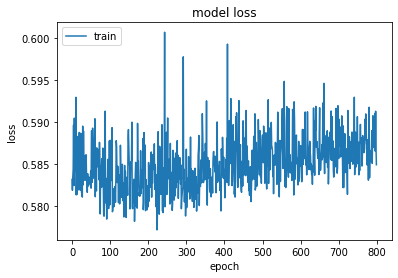

In [4]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)),
                    batch_size=1024,epochs=1000)

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][200:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

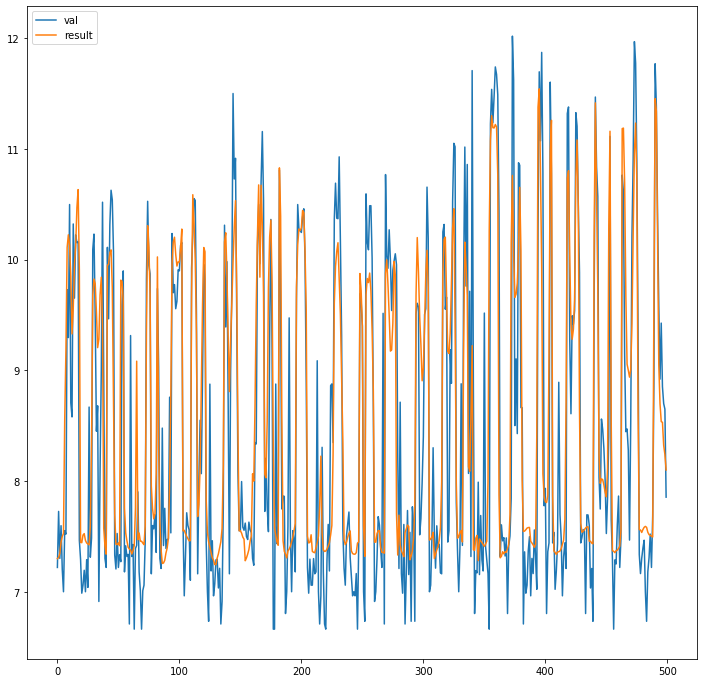

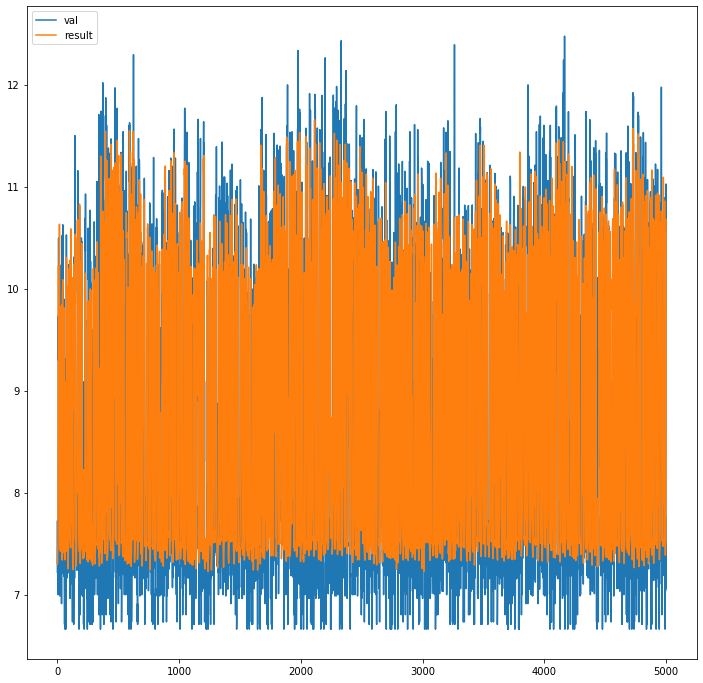

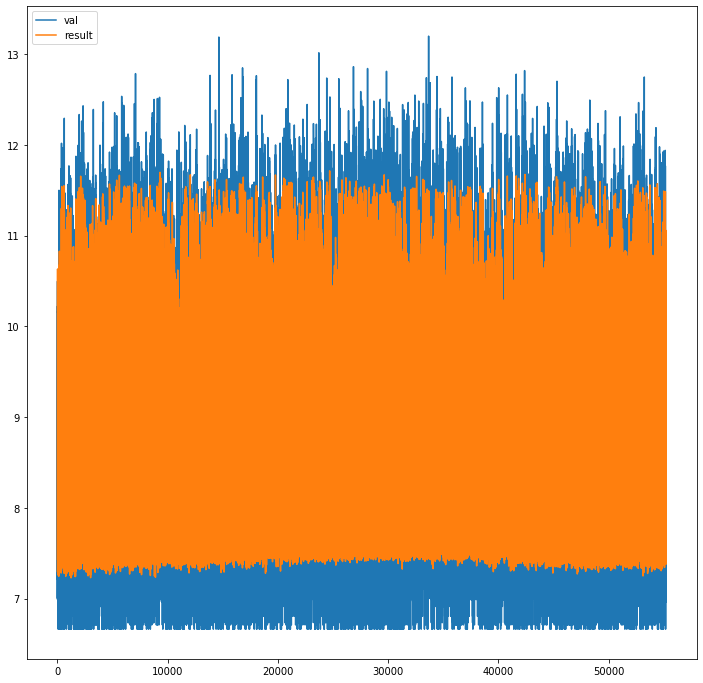

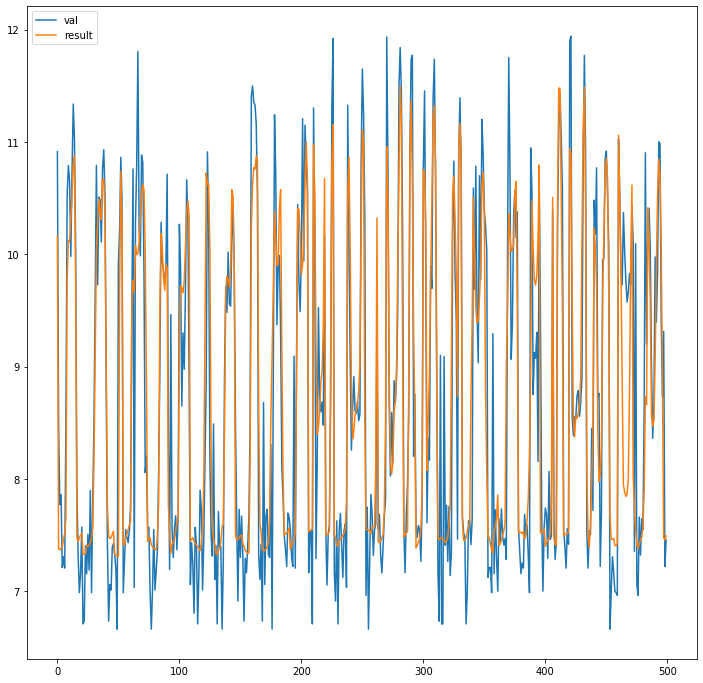

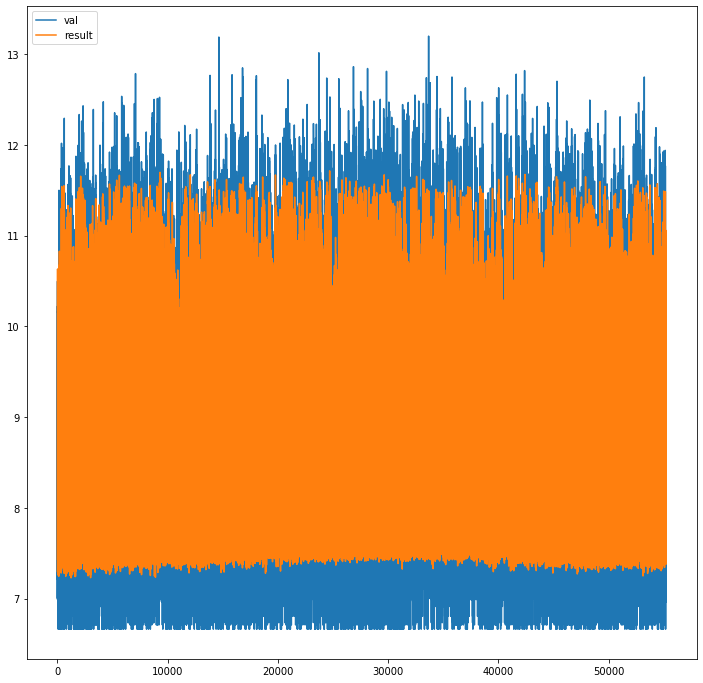

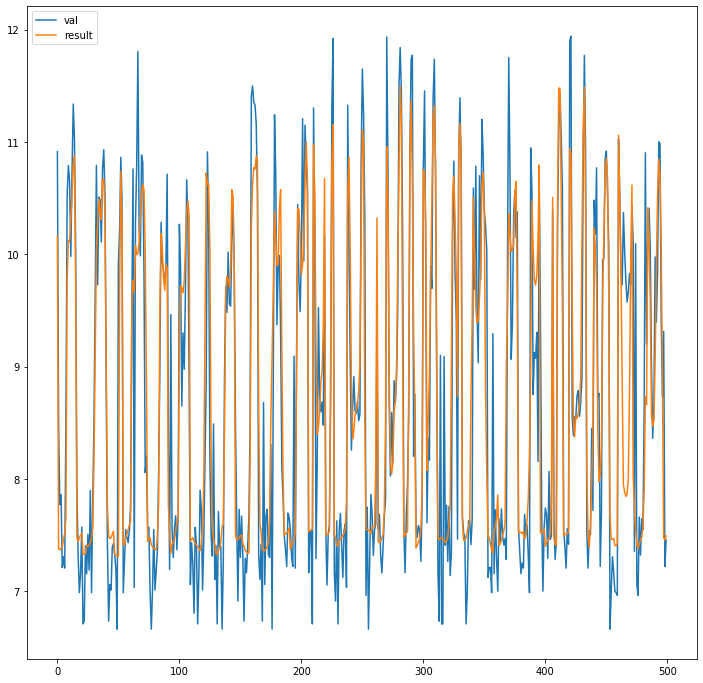

In [5]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)


plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

# Read in the the auroral regions from a pickle file (constructed from auroral boundary transition points) 

In [6]:
# df_val.to_pickle('with_aurora_type_val.pkl')
# df_train.to_pickle('with_aurora_type_train.pkl')
df_val = pd.read_pickle("./with_aurora_type_val.pkl")
df_train = pd.read_pickle("./with_aurora_type_train.pkl")



In [7]:
sum(df_val['aurora_type']==5)/df_val['aurora_type'].shape[0]

0.564933888788263

In [8]:
sum(df_train['aurora_type']==5)/df_train['aurora_type'].shape[0]

0.5490338676186004

# The boundary transition type regions can be reduced to 3 instead of 4 regions (plus unknown region 5), because going into the auroal region from the equatorial region or the polar region is the same for our intention of labeling just equatorial region, auroral, region, or polar region. 

# therefore type 4 is the same as type 1

In [9]:
df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1


False
False
False


(array([ 7048.,     0., 10174.,     0.,     0.,  6626.,     0.,     0.,
            0., 31190.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

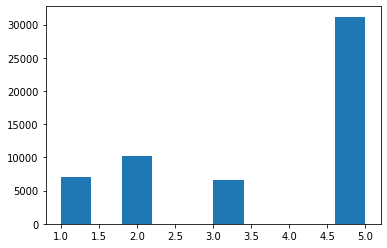

In [10]:

mask = ( np.isnan(df_train['aurora_type'])==False )
df_train_clean = df_train[mask].copy(deep=True)
print((mask.any())==False)
mask = ( np.isnan(df_val['aurora_type'])==False)
df_val_clean = df_val[mask].copy(deep=True)

print(np.isnan(df_val_clean).any().any())
print(np.isnan(df_train_clean).any().any())



plt.hist(df_val_clean['aurora_type'])

In [11]:

# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
from sklearn import preprocessing
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

%matplotlib inline  
import matplotlib.pyplot as plt
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)


In [12]:
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

In [13]:

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

(720998,)
(720998,)
(720998, 148)
(720998,)
(720998, 4)


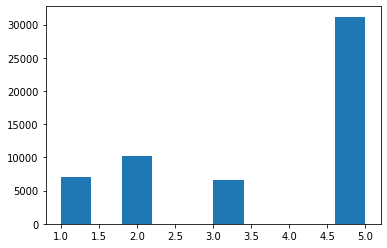

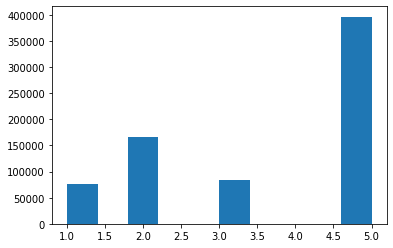

In [14]:
plt.hist(y_val_aurora_type)
plt.show()
plt.hist(y_train_aurora_type)
plt.show()

False
(324651,)
(324651,)
(324651, 148)
(324651,)
(324651, 3)


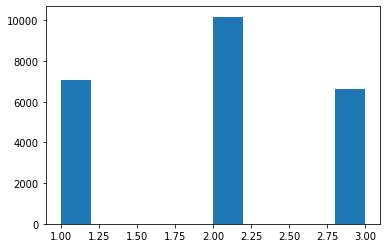

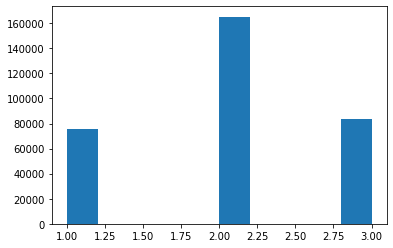

In [15]:

mask = [ (np.isnan(df_train['aurora_type'])==False) & (df_train['aurora_type'] != 5 ) ]
df_train_clean = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==False) & (df_val['aurora_type'] != 5 ) ]
df_val_clean = df_val[mask[0]].copy(deep=True)



# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
from sklearn import preprocessing
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))


X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)

X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

sum(df_val_clean['aurora_type']==2)/df_val_clean.shape[0]
sum(df_train_clean['aurora_type']==2)/df_train_clean.shape[0]



plt.hist(y_val_aurora_type)
plt.show()
plt.hist(y_train_aurora_type)
plt.show()

In [ ]:
model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(4,activation='softmax'))
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3,activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])

history = model.fit(X_train_no_aurora_type_scaled, y_train_aurora_type_encoded, validation_data=(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded), batch_size=32,epochs=1000)

Epoch 1/1000
10146/10146 [==============================] - 32s 3ms/step - loss: 0.3118 - accuracy: 0.8681 - val_loss: 0.2389 - val_accuracy: 0.9003
Epoch 2/1000
10146/10146 [==============================] - 32s 3ms/step - loss: 0.2370 - accuracy: 0.9005 - val_loss: 0.2215 - val_accuracy: 0.9072
Epoch 3/1000
10146/10146 [==============================] - 32s 3ms/step - loss: 0.2230 - accuracy: 0.9066 - val_loss: 0.2174 - val_accuracy: 0.9065
Epoch 4/1000
10146/10146 [==============================] - 34s 3ms/step - loss: 0.2169 - accuracy: 0.9091 - val_loss: 0.2160 - val_accuracy: 0.9063
Epoch 5/1000
10146/10146 [==============================] - 35s 3ms/step - loss: 0.2116 - accuracy: 0.9113 - val_loss: 0.1964 - val_accuracy: 0.9174
Epoch 6/1000
10146/10146 [==============================] - 35s 3ms/step - loss: 0.2086 - accuracy: 0.9129 - val_loss: 0.2023 - val_accuracy: 0.9122
Epoch 7/1000
10146/10146 [==============================] - 35s 3ms/step - loss: 0.2062 - accuracy: 0.9139

10146/10146 [==============================] - 31s 3ms/step - loss: 0.1807 - accuracy: 0.9258 - val_loss: 0.1968 - val_accuracy: 0.9155
Epoch 56/1000
10146/10146 [==============================] - 31s 3ms/step - loss: 0.1785 - accuracy: 0.9255 - val_loss: 0.1945 - val_accuracy: 0.9163
Epoch 57/1000
10146/10146 [==============================] - 32s 3ms/step - loss: 0.1795 - accuracy: 0.9254 - val_loss: 0.1908 - val_accuracy: 0.9190
Epoch 58/1000
10146/10146 [==============================] - 30s 3ms/step - loss: 0.1776 - accuracy: 0.9264 - val_loss: 0.1892 - val_accuracy: 0.9173
Epoch 59/1000
10146/10146 [==============================] - 30s 3ms/step - loss: 0.1780 - accuracy: 0.9258 - val_loss: 0.1935 - val_accuracy: 0.9191
Epoch 60/1000
10146/10146 [==============================] - 31s 3ms/step - loss: 0.1811 - accuracy: 0.9263 - val_loss: 0.1893 - val_accuracy: 0.9175
Epoch 61/1000
10146/10146 [==============================] - 30s 3ms/step - loss: 0.1807 - accuracy: 0.9260 - val_

10146/10146 [==============================] - 23s 2ms/step - loss: 0.1722 - accuracy: 0.9287 - val_loss: 0.1926 - val_accuracy: 0.9179
Epoch 110/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1733 - accuracy: 0.9282 - val_loss: 0.1942 - val_accuracy: 0.9154
Epoch 111/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1715 - accuracy: 0.9281 - val_loss: 0.1912 - val_accuracy: 0.9186
Epoch 112/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1715 - accuracy: 0.9284 - val_loss: 0.1900 - val_accuracy: 0.9176
Epoch 113/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1718 - accuracy: 0.9285 - val_loss: 0.1933 - val_accuracy: 0.9180
Epoch 114/1000
10146/10146 [==============================] - 23s 2ms/step - loss: 0.1730 - accuracy: 0.9281 - val_loss: 0.1981 - val_accuracy: 0.9133
Epoch 115/1000
10146/10146 [==============================] - 23s 2ms/step - loss: 0.1719 - accuracy: 0.9286 

10146/10146 [==============================] - 25s 2ms/step - loss: 0.1671 - accuracy: 0.9301 - val_loss: 0.1924 - val_accuracy: 0.9174
Epoch 164/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1689 - accuracy: 0.9302 - val_loss: 0.1968 - val_accuracy: 0.9182
Epoch 165/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1667 - accuracy: 0.9304 - val_loss: 0.1972 - val_accuracy: 0.9174
Epoch 166/1000
10146/10146 [==============================] - 23s 2ms/step - loss: 0.1760 - accuracy: 0.9305 - val_loss: 0.1910 - val_accuracy: 0.9163
Epoch 167/1000
10146/10146 [==============================] - 23s 2ms/step - loss: 0.1676 - accuracy: 0.9304 - val_loss: 0.1892 - val_accuracy: 0.9174
Epoch 168/1000
10146/10146 [==============================] - 25s 2ms/step - loss: 0.1675 - accuracy: 0.9303 - val_loss: 0.1923 - val_accuracy: 0.9162
Epoch 169/1000
10146/10146 [==============================] - 24s 2ms/step - loss: 0.1663 - accuracy: 0.9311 

10146/10146 [==============================] - 20s 2ms/step - loss: 0.1651 - accuracy: 0.9318 - val_loss: 0.1915 - val_accuracy: 0.9148
Epoch 218/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1650 - accuracy: 0.9315 - val_loss: 0.1918 - val_accuracy: 0.9169
Epoch 219/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1646 - accuracy: 0.9322 - val_loss: 0.1970 - val_accuracy: 0.9158
Epoch 220/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1635 - accuracy: 0.9321 - val_loss: 0.1931 - val_accuracy: 0.9178
Epoch 221/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1637 - accuracy: 0.9319 - val_loss: 0.1955 - val_accuracy: 0.9165
Epoch 222/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1641 - accuracy: 0.9323 - val_loss: 0.2021 - val_accuracy: 0.9142
Epoch 223/1000
10146/10146 [==============================] - 19s 2ms/step - loss: 0.1642 - accuracy: 0.9320 

10146/10146 [==============================] - 17s 2ms/step - loss: 0.1620 - accuracy: 0.9321 - val_loss: 0.1952 - val_accuracy: 0.9182
Epoch 272/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1618 - accuracy: 0.9328 - val_loss: 0.1973 - val_accuracy: 0.9180
Epoch 273/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1638 - accuracy: 0.9328 - val_loss: 0.1951 - val_accuracy: 0.9170
Epoch 274/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1611 - accuracy: 0.9328 - val_loss: 0.2025 - val_accuracy: 0.9157
Epoch 275/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1636 - accuracy: 0.9322 - val_loss: 0.1919 - val_accuracy: 0.9193
Epoch 276/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1620 - accuracy: 0.9331 - val_loss: 0.1937 - val_accuracy: 0.9174
Epoch 277/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1709 - accuracy: 0.9327 

10146/10146 [==============================] - 16s 2ms/step - loss: 0.1627 - accuracy: 0.9324 - val_loss: 0.1943 - val_accuracy: 0.9189
Epoch 326/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1634 - accuracy: 0.9335 - val_loss: 0.1954 - val_accuracy: 0.9166
Epoch 327/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1587 - accuracy: 0.9339 - val_loss: 0.1960 - val_accuracy: 0.9171
Epoch 328/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1648 - accuracy: 0.9339 - val_loss: 0.1943 - val_accuracy: 0.9148
Epoch 329/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1615 - accuracy: 0.9332 - val_loss: 0.1954 - val_accuracy: 0.9169
Epoch 330/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1621 - accuracy: 0.9336 - val_loss: 0.1996 - val_accuracy: 0.9163
Epoch 331/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1631 - accuracy: 0.9331 

10146/10146 [==============================] - 16s 2ms/step - loss: 0.1680 - accuracy: 0.9338 - val_loss: 0.1958 - val_accuracy: 0.9153
Epoch 380/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1602 - accuracy: 0.9337 - val_loss: 0.1961 - val_accuracy: 0.9172
Epoch 381/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.2084 - accuracy: 0.9340 - val_loss: 0.1988 - val_accuracy: 0.9183
Epoch 382/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1603 - accuracy: 0.9338 - val_loss: 0.2027 - val_accuracy: 0.9175
Epoch 383/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1597 - accuracy: 0.9343 - val_loss: 0.2017 - val_accuracy: 0.9183
Epoch 384/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1587 - accuracy: 0.9343 - val_loss: 0.2004 - val_accuracy: 0.9184
Epoch 385/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1584 - accuracy: 0.9348 

10146/10146 [==============================] - 16s 2ms/step - loss: 0.1638 - accuracy: 0.9351 - val_loss: 0.1974 - val_accuracy: 0.9174
Epoch 434/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1674 - accuracy: 0.9348 - val_loss: 0.2034 - val_accuracy: 0.9186
Epoch 435/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1575 - accuracy: 0.9348 - val_loss: 0.1955 - val_accuracy: 0.9186
Epoch 436/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1586 - accuracy: 0.9344 - val_loss: 0.2001 - val_accuracy: 0.9187
Epoch 437/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1618 - accuracy: 0.9352 - val_loss: 0.1988 - val_accuracy: 0.9154
Epoch 438/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1632 - accuracy: 0.9347 - val_loss: 0.1962 - val_accuracy: 0.9181
Epoch 439/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1582 - accuracy: 0.9355 

10146/10146 [==============================] - 17s 2ms/step - loss: 0.1592 - accuracy: 0.9356 - val_loss: 0.1980 - val_accuracy: 0.9189
Epoch 488/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1575 - accuracy: 0.9346 - val_loss: 0.1956 - val_accuracy: 0.9183
Epoch 489/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1581 - accuracy: 0.9353 - val_loss: 0.2016 - val_accuracy: 0.9155
Epoch 490/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1710 - accuracy: 0.9348 - val_loss: 0.2034 - val_accuracy: 0.9187
Epoch 491/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1590 - accuracy: 0.9357 - val_loss: 0.1990 - val_accuracy: 0.9194
Epoch 492/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1578 - accuracy: 0.9345 - val_loss: 0.1975 - val_accuracy: 0.9173
Epoch 493/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1590 - accuracy: 0.9350 

10146/10146 [==============================] - 18s 2ms/step - loss: 0.1616 - accuracy: 0.9361 - val_loss: 0.2017 - val_accuracy: 0.9173
Epoch 542/1000
10146/10146 [==============================] - 19s 2ms/step - loss: 0.1615 - accuracy: 0.9357 - val_loss: 0.2010 - val_accuracy: 0.9171
Epoch 543/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1697 - accuracy: 0.9353 - val_loss: 0.1990 - val_accuracy: 0.9161
Epoch 544/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1569 - accuracy: 0.9355 - val_loss: 0.2046 - val_accuracy: 0.9148
Epoch 545/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1596 - accuracy: 0.9355 - val_loss: 0.2011 - val_accuracy: 0.9183
Epoch 546/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1606 - accuracy: 0.9359 - val_loss: 0.2006 - val_accuracy: 0.9178
Epoch 547/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1617 - accuracy: 0.9361 

10146/10146 [==============================] - 17s 2ms/step - loss: 0.1723 - accuracy: 0.9359 - val_loss: 0.1980 - val_accuracy: 0.9175
Epoch 596/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1628 - accuracy: 0.9360 - val_loss: 0.2079 - val_accuracy: 0.9150
Epoch 597/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1676 - accuracy: 0.9354 - val_loss: 0.2097 - val_accuracy: 0.9135
Epoch 598/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1577 - accuracy: 0.9360 - val_loss: 0.1994 - val_accuracy: 0.9173
Epoch 599/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1570 - accuracy: 0.9370 - val_loss: 0.2011 - val_accuracy: 0.9162
Epoch 600/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1700 - accuracy: 0.9362 - val_loss: 0.2035 - val_accuracy: 0.9169
Epoch 601/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1593 - accuracy: 0.9365 

10146/10146 [==============================] - 16s 2ms/step - loss: 0.1627 - accuracy: 0.9368 - val_loss: 0.2036 - val_accuracy: 0.9166
Epoch 650/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1603 - accuracy: 0.9366 - val_loss: 0.2036 - val_accuracy: 0.9175
Epoch 651/1000
10146/10146 [==============================] - 16s 2ms/step - loss: 0.1571 - accuracy: 0.9367 - val_loss: 0.2022 - val_accuracy: 0.9175
Epoch 652/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1598 - accuracy: 0.9367 - val_loss: 0.2029 - val_accuracy: 0.9158
Epoch 653/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1604 - accuracy: 0.9362 - val_loss: 0.2017 - val_accuracy: 0.9149
Epoch 654/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1579 - accuracy: 0.9366 - val_loss: 0.2031 - val_accuracy: 0.9173
Epoch 655/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1536 - accuracy: 0.9372 

10146/10146 [==============================] - 22s 2ms/step - loss: 0.1548 - accuracy: 0.9372 - val_loss: 0.2044 - val_accuracy: 0.9170
Epoch 704/1000
10146/10146 [==============================] - 22s 2ms/step - loss: 0.1662 - accuracy: 0.9362 - val_loss: 0.2001 - val_accuracy: 0.9163
Epoch 705/1000
10146/10146 [==============================] - 21s 2ms/step - loss: 0.1583 - accuracy: 0.9370 - val_loss: 0.1984 - val_accuracy: 0.9173
Epoch 706/1000
10146/10146 [==============================] - 22s 2ms/step - loss: 0.1546 - accuracy: 0.9364 - val_loss: 0.2031 - val_accuracy: 0.9175
Epoch 707/1000
10146/10146 [==============================] - 17s 2ms/step - loss: 0.1542 - accuracy: 0.9367 - val_loss: 0.1963 - val_accuracy: 0.9172
Epoch 708/1000
10146/10146 [==============================] - 18s 2ms/step - loss: 0.1602 - accuracy: 0.9366 - val_loss: 0.1993 - val_accuracy: 0.9162
Epoch 709/1000
10146/10146 [==============================] - 15s 2ms/step - loss: 0.1563 - accuracy: 0.9366 

In [ ]:
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][100:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][100:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['accuracy'][50:])
plt.plot(history.history['val_accuracy'][50:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['accuracy'][100:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_accuracy'][100:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


results = (model.predict_classes(X_val_no_aurora_type_scaled))#, y_val_log.values)#, batch_size=128)



# plt.figure(figsize=(12,12))

# plt.plot( integer_encoded_val[:3000])
# plt.plot(results[:3000])
# plt.show()
plt.figure(figsize=(12,12))

plt.plot( integer_encoded_val[:100])
plt.plot(results[:100])
plt.show()

plt.figure(figsize=(12,12))

plt.plot( integer_encoded_val[:500])
plt.plot(results[:500])
plt.show()

In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3,activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])

history = model.fit(X_train_no_aurora_type_scaled, y_train_aurora_type_encoded, validation_data=(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded), batch_size=32,epochs=75)

In [ ]:
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Now use this Auroal region predictor model to predict what type the "unknown/unspecified" regions are.  Then combine this predicted data with the known training and test data

In [ ]:
 
mask = [ (np.isnan(df_train['aurora_type'])==True) | (df_train['aurora_type'] == 5 ) ]
df_train_pred = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==True) | (df_val['aurora_type'] == 5 ) ]
df_val_pred = df_val[mask[0]].copy(deep=True)
print(df_train_pred.shape)
print(df_val_pred.shape)

In [ ]:
print(df_train_pred.columns)

# Construct X and y
feature_cols = [c for c in df_train_pred.columns if (not ( 'ELE' in c) | ('aurora_type' in c))]
X_train = df_train_pred[feature_cols].copy(deep=True)
X_val = df_val_pred[feature_cols].copy(deep=True)
print(X_train.shape)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)
#scaler_X = scaler_X.fit(X_train_no_aurora_type.values)



In [ ]:

print(X.shape)

print((model.predict_classes(X_train_no_aurora_type_scaled)).shape)
print(df_train_pred.shape)

df_train_pred['aurora_type']= model.predict_classes(X)+1
df_val_pred['aurora_type']= model.predict_classes(X_test)+1

print(df_train_pred.shape)
print(df_train_clean.shape)

frames = [df_train_clean, df_train_pred]
df_train_new = pd.concat(frames)
frames = [df_val_clean, df_val_pred]
df_val_new = pd.concat(frames) 

In [ ]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
from sklearn import preprocessing
X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

%matplotlib inline  
import matplotlib.pyplot as plt
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000)

In [ ]:
filename = 'best_with_auroral_region2'
model.save(filename)

# model = tensorflow.keras.models.load_model(filename)
model.save(filename)
# model.save_weights('my_model_weights2.h5')


print(history.history.keys())
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][200:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][500:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)


plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

# The target Y is now a vector result where the true value only has one of the three as non-zero, the correct answer is specified by the auroral region type, equatorial region, in aurora, and the polar region

# The loss is the MSE of all three, to compare this loss to the previous approach that is signal modal, multiply the loss by the number of modes which is three

In [ ]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]
X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train_val = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log1 = np.log10(y_train.copy(deep=True))
y_val_log1 = np.log10(y_val.copy(deep=True))

y_train_log = np.zeros((y_train_log1.values.shape[0],3))
y_val_log = np.zeros((y_val_log1.values.shape[0],3))

for i in range(0,X_val.values.shape[0]):
    if X_val['aurora_type'].values[i] == 1:
        y_val_log[i,0]=y_val_log1.values[i]
    if X_val['aurora_type'].values[i] == 2:
        y_val_log[i,1]=y_val_log1.values[i]
    if X_val['aurora_type'].values[i] == 3:
        y_val_log[i,2]=y_val_log1.values[i]
for i in range(0,X_train.values.shape[0]):
    if X_train['aurora_type'].values[i] == 1:
        y_train_log[i,0]=y_train_log1.values[i]
    if X_train['aurora_type'].values[i] == 2:
        y_train_log[i,1]=y_train_log1.values[i]
    if X_train['aurora_type'].values[i] == 3:
        y_train_log[i,2]=y_train_log1.values[i]



scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)



In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
#model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000)

In [ ]:
results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])
    
plt.figure(figsize=(12,12))
plt.plot(y[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1000)

In [ ]:
filename = 'best_with_auroral_region4'

# model = tensorflow.keras.models.load_model(filename)
model.save(filename)
# model.save_weights('my_model_weights2.h5')


print(history.history.keys())
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
# summarize history for loss
plt.plot(history.history['val_loss'][200:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])
    
plt.figure(figsize=(12,12))
plt.plot(y[:500])
plt.plot(results[:500])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[:5000])
plt.plot(results[:5000])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[:])
plt.plot(results[:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y[-500:])
plt.plot(results[-500:])
plt.legend(['val', 'result'], loc='upper left')
plt.show()

# Trying Multi-modal without auroral region type as input for X
(but still using the auroal type to specify y_train and y_val for which of the three modes it is in)

In [ ]:
feature_cols = [c for c in X_val.columns if not 'aurora_type' in c]
X_val = X_val[feature_cols].copy(deep=True)
X_train = X_train[feature_cols].copy(deep=True)

scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
#model.add(Dropout(.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(3))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=10)

In [ ]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=100)

In [ ]:
# filename = 'best_with_auroral_region3'

# # model = tensorflow.keras.models.load_model(filename)
# model.save(filename)
# # model.save_weights('my_model_weights2.h5')


print(history.history.keys())
plt.figure()
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:
results1 = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
print(results1.shape[0])
results = np.zeros((results1.shape[0]))
y = np.zeros((results1.shape[0]))
print(y.shape)
for i in range(0,results1.shape[0]):
    results[i]= np.max(results1[i,:])
    y[i] = np.max(y_val_log[i,:])
    
plt.figure(figsize=(12,12))
plt.plot(y[:100])
plt.plot(results[:100])
plt.legend(['val', 'result'], loc='upper left')
plt.show()
